My household listens to a lot of Taylor Swift music.
Inspired by this and her Eras tour, I decided to take a look at some of her song data available on Spotify.
In this example, I'm visualizing the data with plotly.
These plots are more interactive, but will not render correctly in Github, so I would recommend viewing the notebook using nbviewer.

**Follow the link below to view the interactive plots!**

[nbviewer link](https://nbviewer.org/github/jaredcarter/data-science-portfolio/blob/main/spotify-data/Eras.ipynb?flush_cache=True)

First we have to import the required packages.

In [1]:
import pandas as pd
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns


Next, we need to import the data.
This data was pulled from Spotify using the [Get Spotify Playlist Data](Get%20Spotify%20Playlist%20Data.ipynb) notebook.

In [2]:
df = pd.read_csv("data/Taylor Swift.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   added_at                            254 non-null    object 
 1   is_local                            254 non-null    bool   
 2   primary_color                       0 non-null      float64
 3   added_by.external_urls.spotify      254 non-null    object 
 4   added_by.href                       254 non-null    object 
 5   added_by.id                         254 non-null    object 
 6   added_by.type                       254 non-null    object 
 7   added_by.uri                        254 non-null    object 
 8   track.album.album_type              254 non-null    object 
 9   track.album.artists                 254 non-null    object 
 10  track.album.available_markets       254 non-null    object 
 11  track.album.external_urls.spotify   254 non-n

The output above shows what columns of data are available to us.
Some of the not-so-straightforward column names are explained in [Spotify's API documentation](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features).
The last bit of pre-processing for now is to format the `track.album.release_date` as a datetime object.

In [3]:
df['track.album.release_date'] = pd.to_datetime(df['track.album.release_date'])

Let's look at the album release dates in chronological order.
To achieve this, we will use a scatter plot.
The x-axis will be the release date and the y-axis will show the average popularity.
The size of the marker will be proportional to the number of tracks on each album.

In [4]:
date_pop_data = (df.groupby('track.album.name')
                 # aggregate different columns differently
                 # find the median release date
                 .agg({'track.album.release_date': 'median',
                       # find the mean popularity
                       'track.popularity': 'mean',
                       # find the number of tracks
                       'track.id': 'count'})
                       .reset_index())

# Create figure using plotly
figure = px.scatter(date_pop_data,
    # x axis is the median release date
    x='track.album.release_date',
    # y axis is mean popularity
    y='track.popularity',
    # size is count of tracks
    size='track.id',
    # color by album name
    color='track.album.name',
    # make labels more accurate
    labels={'track.album.release_date': 'Release Date',
            'track.popularity': 'Average Popularity',
            'track.id': 'Count of Album Tracks',
            'track.album.name': 'Album Name'})
figure

If you are viewing this notebook in nbviewer, feel free to hover over the data points to see more information. You can also click on the legend to show/hide particular albums.

The first observation that one might make from this figure is that Taylor Swift's recent albums are more popular than her older music, but that isn't entirely accurate.
Loyal Taylor Swift fans only stream [Taylor's Version](https://cherokeehighnews.com/2022/03/11/taylors-version-vs-the-original-whats-the-difference/) of her albums, for reasons described in the linked article.
This results in a lower average popularity for albums which have a corresponding Taylor's version.

Now I'm curious about the popularity of songs in albums that have a corresponding Taylor's version.
This will be plotted using a split violin plot in plotly


In [5]:
# Get first word of album name to group Taylor and non-taylor versions of songs
df['track.album.group'] = df['track.album.name'].str.replace(" (Taylor's Version)", "").str.replace(" [Deluxe]", "")
# True if Taylor owns the song
df['track.taylor_owns'] = df['track.album.release_date'] > '2018-11-01'
# only look at albums with a Taylor and non-Taylor version
taylor_vs_non = df[df['track.album.group'].isin(['1989', 'Fearless', 'Red', 'Speak Now'])]

# initialize the graph object
fig = go.Figure()

# Plot the non-Taylor's version violin plot
# x-axis is the album group
fig.add_trace(go.Violin(x=taylor_vs_non['track.album.group'][taylor_vs_non['track.taylor_owns'] == False],
                        # y-axis is the popularity
                        y=taylor_vs_non['track.popularity'][taylor_vs_non['track.taylor_owns'] == False],
                        # descriptive text is the track name
                        text=taylor_vs_non['track.name'][taylor_vs_non['track.taylor_owns'] == False],
                        # Label the legend and show all data points
                        legendgroup='No', scalegroup='No', name='No', points='all', hoverinfo='text',
                        # make the mean line visible
                        meanline_visible=True,
                        side='negative'))

fig.add_trace(go.Violin(x=taylor_vs_non['track.album.group'][taylor_vs_non['track.taylor_owns'] == True],
                        y=taylor_vs_non['track.popularity'][taylor_vs_non['track.taylor_owns'] == True],
                        text=taylor_vs_non['track.name'][taylor_vs_non['track.taylor_owns'] == True],
                        legendgroup='Yes', scalegroup='Yes', name='Yes', points='all', hoverinfo='text',
                        meanline_visible=True,
                        side='positive'))

fig.update_layout(title_text="Popularity of Taylor Swift Songs by album and Taylor's Version Status")
fig.update_xaxes(title_text='Album')
fig.update_yaxes(title_text="Popularity")

fig

In the figure above, the red data points and violin plot correspond to Taylor's Version of songs, while the blue points are from the older version of the album.
For all albums, Taylor's version has a higher mean popularity than the older version.
The only album where there isn't a profound separation between album types is 1989, which is probably because Taylor's version was released less than three months before the time of writing this article.
Some of the songs on the Taylor's Version albums do not appear in the original album.
These tracks are labeled with (From the Vault) and appear to be among the most popular songs in the album.
Let's flag the Vault tracks to see if they are more or less popular than average.

In [6]:
vault = taylor_vs_non[taylor_vs_non['track.taylor_owns'] == True].copy()
vault['track.from_vault'] = vault['track.name'].str.contains('Vault')

fig = px.scatter(vault,
                 x='valence', y='track.popularity', color='track.from_vault',
                 hover_name='track.name',
                 facet_col='track.album.name', facet_col_wrap=2,
                 labels={'track.from_vault': 'From the Vault',
                        'track.popularity': 'Average Popularity',
                        'track.album.name': 'Album Name'})

fig

Here we have one plot per album, with popularity on the y-axis and valence, or how positive or negative the song seems to Spotify on the x-axis.
While I would suspect that people that are knowledgeable with Taylor Swift's discography would disagree with the valence of many of these songs, it seems that the Vault tracks are not more or less popular than the other songs on the album, with the exception of "All to Well (10 Minute Version) (Taylor's Version) (From the Vault)".

Spotify offers other song metrics on a scale of 0 to 1.
Let's see if categories such as "acousticness", "energy", or "danceability" are different for the different albums.
Moving forward, we will only use versions of albums that Taylor Swift owns, unless she has yet to release a new version.

In [7]:
# identify tracks on albums from non-Taylor's version
new_df = df[~df['track.album.name'].isin(['1989', 'Fearless', 'Red', 'Speak Now'])]

First, we will see if any of these variables are correlated.

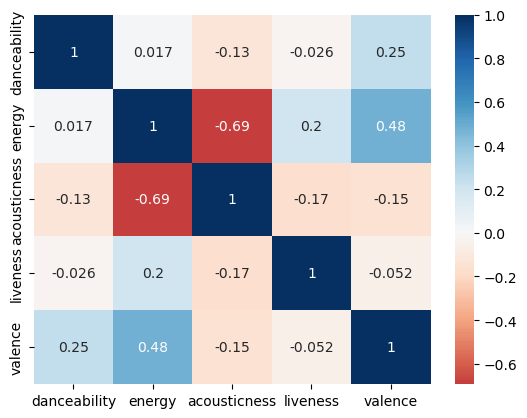

In [8]:
corr = new_df[['danceability', 'energy', 'acousticness', 'liveness', 'valence']].corr()
sns.heatmap(corr, annot=True, center=0, cmap='RdBu')
plt.show()

I would have expected energy and danceability to be correlated, but that doesn't seem to be the case here.
The biggest takeaways are that Taylor Swift songs that are lower energy are more acoustic, and songs with lower energy also tend to have lower valence.

In [14]:
fig = px.box(new_df, y=['danceability', 'energy'],
             color='track.album.name', hover_name='track.name', points='all', 
             labels={'track.album.name': 'Album Name',
                     'track.name': 'Track Name'})
fig.update_traces(boxmean=True)
fig

Here we see that Lover had the most danceable and least danceable song (I Think He Knows and The Archer, respectively).
Most Taylor Swift albums had an average danceability around 0.6, with the average album energy varying from 0.42 to 0.66.
Again, feel free to hover your mouse over the data points to see where your favorite songs rank.

In [15]:
fig = px.box(new_df, y=['acousticness', 'speechiness'],
             color='track.album.name', hover_name='track.name', points='all')
fig.update_traces(boxmean=True)
fig

In [16]:
fig = px.box(new_df, y=['liveness', 'valence'],
             color='track.album.name', hover_name='track.name', points='all')
fig.update_traces(boxmean=True)
fig

Finally, we might want to visuzalze an album's song data in 3d.

In [20]:
fig = px.scatter_3d(new_df[new_df['track.album.name'] == "Red (Taylor's Version)"],
                    x='valence', y='energy', z='danceability', color='track.popularity',
                    size='track.duration_ms',
                    hover_name='track.name',
                    labels={'track.popularity': 'Popularity',
                            'track.name': 'Name',
                            'track.duration_ms': 'Track Duration (ms)'})
fig